Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


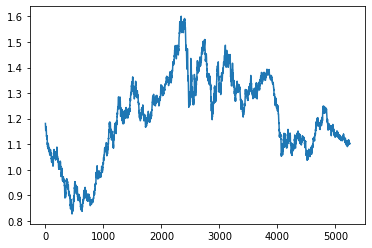

In [0]:
import pandas
import matplotlib.pyplot as plt
from google.colab import drive
import os
drive.mount('/content/gdrive')
os.getcwd()+"/gdrive/My Drive"
os.chdir('/content/gdrive/My Drive/')
dataset = pandas.read_csv("DEXUSEU_2.csv", usecols=[1], engine='python')
plt.plot(dataset)
plt.show()

Train on 2355 samples, validate on 1160 samples
Epoch 1/200
 - 5s - loss: 0.1980 - mean_absolute_error: 0.3830 - val_loss: 0.4475 - val_mean_absolute_error: 0.6608
Epoch 2/200
 - 0s - loss: 0.1927 - mean_absolute_error: 0.3764 - val_loss: 0.4375 - val_mean_absolute_error: 0.6532
Epoch 3/200
 - 0s - loss: 0.1874 - mean_absolute_error: 0.3699 - val_loss: 0.4278 - val_mean_absolute_error: 0.6458
Epoch 4/200
 - 0s - loss: 0.1823 - mean_absolute_error: 0.3634 - val_loss: 0.4180 - val_mean_absolute_error: 0.6383
Epoch 5/200
 - 0s - loss: 0.1773 - mean_absolute_error: 0.3571 - val_loss: 0.4086 - val_mean_absolute_error: 0.6309
Epoch 6/200
 - 0s - loss: 0.1724 - mean_absolute_error: 0.3507 - val_loss: 0.3993 - val_mean_absolute_error: 0.6235
Epoch 7/200
 - 0s - loss: 0.1676 - mean_absolute_error: 0.3445 - val_loss: 0.3901 - val_mean_absolute_error: 0.6162
Epoch 8/200
 - 0s - loss: 0.1629 - mean_absolute_error: 0.3383 - val_loss: 0.3810 - val_mean_absolute_error: 0.6088
Epoch 9/200
 - 0s - loss

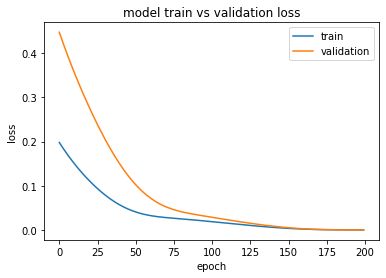

Train Score: 0.00872 RMSE
Test Score: 0.00661 RMSE


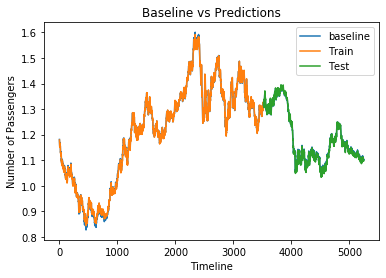

In [0]:
# LSTM for international airline passengers problem with time step regression framing
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.optimizers import Adam
from keras.optimizers import SGD
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)

# load the dataset
# convert to floating

dataframe = read_csv('DEXUSEU_2.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

# normalize the dataset
# LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. 
# It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing. 
# We can easily normalize the dataset using the MinMaxScaler preprocessing class from the scikit-learn library.

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
# calculates the index of the split point and separates the data into the training datasets 
# with 67% of the observations that we can use to train our model, leaving the remaining 33% for testing the model.

train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1
# The function takes two arguments: the dataset, which is a NumPy array that we want to convert into a dataset, 
# and the look_back, which is the number of previous time steps to use as input variables to predict the next time period
# in this case defaulted to 1.
# This default will create a dataset where X is the number of passengers at a given time (t) and Y is the number of passengers at the next time (t + 1).

look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Currently, our data is in the form: [samples, features] and we are framing the problem as one time step for each sample. 
# We can transform the prepared train and test input data into the expected structure using numpy.reshape()
# reshape input to be [samples, time steps, features]

trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

# create and fit the LSTM network
# The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, 
# and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. 
# The network is trained for 100 epochs and a batch size of 1 is used.

model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=Adam(lr= 5e-5), metrics=['mean_absolute_error'])
history = model.fit(trainX, trainY, epochs=200, batch_size=32, verbose=2,validation_split =0.33)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

# make predictions

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Note that we invert the predictions before calculating error scores 
# to ensure that performance is reported in the same units as the original data (thousands of passengers per month).

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.5f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.5f RMSE' % (testScore))

# Because of how the dataset was prepared, we must shift the predictions so that they align on the x-axis with the original dataset. 
# Once prepared, the data is plotted, showing the original dataset in blue, the predictions for the training dataset in orange,
# and the predictions on the unseen test dataset in green.

# shift train predictions for plotting

trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting

testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
# We can see that the model has an average error of about 5 million on the training dataset, and about 8 million on the test dataset.

plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.title('Baseline vs Predictions')
plt.ylabel('Number of Passengers')
plt.xlabel('Timeline')
plt.legend(['baseline', 'Train','Test'], loc='upper right')
plt.show()